In [1]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.environ import Piecewise
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
import matplotlib.pyplot as plt
from calculations.datahandling import *
from calculations.data_processor import * 
from plotting.plot_generator import *

## Data handling

In [2]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputData(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputData('data/Parameters.xlsx')


def InputData(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start','Vmin_reg','Vmax_reg']].dropna()

    #Volume-head relationship:
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head')
    data_volhead = {}
    data_volhead['ormset_headvol'] = inputdata[['Mm3','m']].dropna()

    #Flow-head relationship:
    inputdata = pd.read_excel(data_file, sheet_name='flow')
    data_flowhead = {}
    data_flowhead['ormset_headflow'] = inputdata[['Moh','m3/s']].dropna()
    return data

topology = InputData('data/Ormset_Data.xlsx')

print(topology)

{'ormset': Ormsetfoss  Pmin  Pmax  Vmax  Vmin  Vstart  Qmin  Qmax  Pump_min  Pump_max  \
Hydro1       0.0  43.0  45.0   0.0    45.0   2.0  12.0       0.0       0.0   
Hydro2       0.0  30.0  20.0   0.0    20.0   2.0  12.0       0.0       1.6   

Ormsetfoss    Q    LRL    HRL  RL_start  Vmin_reg  Vmax_reg  
Hydro1      4.0  375.0  388.0     388.0      35.0      45.0  
Hydro2      2.0  326.0  331.0     331.0      15.0      20.0  }


In [3]:
start = '2018-01-01 00:00:00'
end = '2018-01-01 23:00:00'

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H',columns)
#combined_inflow = {key: value for inner_dict in inflow.values() for key, value in inner_dict.items()}
display(inflow)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2


[{1: 0.8,
  2: 0.0,
  3: 0.0,
  4: 0.86,
  5: 15.63,
  6: 0.0,
  7: 0.76,
  8: 0.76,
  9: 1.98,
  10: 0.76,
  11: 0.76,
  12: 0.76,
  13: 1.98,
  14: 0.76,
  15: 0.76,
  16: 1.98,
  17: 0.76,
  18: 0.76,
  19: 0.76,
  20: 1.92,
  21: 0.76,
  22: 0.76,
  23: 1.98,
  24: 0.0},
 {1: 0.08,
  2: 0.0,
  3: 0.0,
  4: 0.08,
  5: 1.48,
  6: 0.0,
  7: 0.07,
  8: 0.07,
  9: 0.19,
  10: 0.07,
  11: 0.07,
  12: 0.07,
  13: 0.19,
  14: 0.07,
  15: 0.07,
  16: 0.19,
  17: 0.07,
  18: 0.07,
  19: 0.07,
  20: 0.18,
  21: 0.07,
  22: 0.07,
  23: 0.19,
  24: 0.0}]

## Digital twin model to hydro power plant

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key : Value


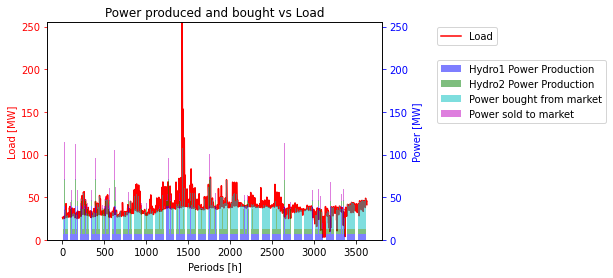

Objective Value: 3890077.4384442763
Model unknown

  Variables:
    p : Size=7248, Index=p_index
        Key              : Lower : Value              : Upper : Fixed : Stale : Domain
           ('Hydro1', 1) :   0.0 :  6.695324999999997 :  43.0 : False : False :  Reals
           ('Hydro1', 2) :   0.0 :           6.695325 :  43.0 : False : False :  Reals
           ('Hydro1', 3) :   0.0 :  6.695324999999997 :  43.0 : False : False :  Reals
           ('Hydro1', 4) :   0.0 :           40.17195 :  43.0 : False : False :  Reals
           ('Hydro1', 5) :   0.0 :           6.695325 :  43.0 : False : False :  Reals
           ('Hydro1', 6) :   0.0 :  6.695324999999997 :  43.0 : False : False :  Reals
           ('Hydro1', 7) :   0.0 :  6.695324999999997 :  43.0 : False : False :  Reals
           ('Hydro1', 8) :   0.0 :           6.695325 :  43.0 : False : False :  Reals
           ('Hydro1', 9) :   0.0 :           6.695325 :  43.0 : False : False :  Reals
          ('Hydro1', 10) :   0.0 

In [5]:
#Definitions
start = '2018-01-01 00:00:00'
end = '2018-05-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'rQ_min': 0, 'rQ_max': 40}

# Create a ConcreteModel
model = pyo.ConcreteModel()

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN

# Sets to model hydro topology
hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour
model.periods = pyo.Set(initialize=range(1, int(hours_difference) + 1, 1))
#model.periods = pyo.Set(initialize=range(1, 25, 1))                   #these sets must be defined in the latex report as well
model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
model.market = pyo.Set(initialize=['DAM','Sell'])

# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
model.eff = pyo.Param(initialize=constants['eff'])
model.rho = pyo.Param(initialize=constants['rho'])
model.g = pyo.Param(initialize=constants['g'])

# Cost parameters
Fi=1000
#max_purchase_limit = 100  # Adjust this value as needed
#model.Fi=pyo.Param(model.market, initialize=Fi)                  #Buy-in market price (initial market price cost)
#model.PurchaseLimit = pyo.Param(initialize=max_purchase_limit)
model.Mi = pyo.Param(model.periods, initialize=avg_market_price)            #Market price varying
model.Ci=pyo.Param(model.plants, initialize=parameters['prod']['Ci'])  #Initial cost for plants
model.yi=pyo.Param(model.plants, initialize=parameters['prod']['yi'])  #Variable costs for plants 

#Plant parameters
model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

#Load parameters
model.L = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})

#Topology parameters
model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
model.rQmin=pyo.Param(model.plants, initialize=constants['rQ_min']) 
model.rQmax=pyo.Param(model.plants, initialize=constants['rQ_max'])
model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
model.inflow1 = pyo.Param(model.periods, initialize=inflow_hydro1)
model.inflow2 = pyo.Param(model.periods, initialize=inflow_hydro2)
model.Vmin_reg = pyo.Param(model.plants, initialize=topology['ormset']['Vmin_reg'])
model.Vmax_reg = pyo.Param(model.plants, initialize=topology['ormset']['Vmax_reg'])
#model.gate = pyo.Param()

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])
model.p = pyo.Var(model.plants, model.periods, bounds=p_bounds)                   #Power production
model.m = pyo.Var(model.market, model.periods, within=NonNegativeReals)       #Power bougth from lack of production

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])
model.q = pyo.Var(model.plants, model.periods, bounds=q_bounds)          #time dependent discharge which varies based on power production

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])
model.pump=pyo.Var(model.plants, model.periods, bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])
def init_v(model, i, j):
    return model.v0[i]
model.v = pyo.Var(model.plants, model.periods, bounds=vol_bounds, initialize=init_v)        #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])
model.h = pyo.Var(model.plants, model.periods, bounds=head_bounds)

def river_flow(model,i,j):                                               #Time dependent variable for river flow from over filling of reservoirs!
    return(model.rQmin[i],model.rQmax[i])
model.rq = pyo.Var(model.plants, model.periods, bounds=river_flow)
model.gate_var = pyo.Var(model.periods, within=pyo.Binary)


#-------------------MODEL OF RESERVOIRS------------------#
model.cumulative_q = pyo.Var(model.plants, model.periods, within=pyo.NonNegativeReals)
model.cumulative_inflow = pyo.Var(model.plants, model.periods, within=pyo.NonNegativeReals)#combining discharge (q [m3/s]) into m3 over given timeframe (NEED TO CHECK CONVERSIONS)
model.cumulative_pump = pyo.Var(model.plants, model.periods, within=pyo.NonNegativeReals)
# Constraint to calculate the cumulative sum of discharges (WATER OUT OF PLANTS)

def cumulative_pump_rule(model, i, j):
    if j == 1:
        if i == 'Hydro1':
            return model.cumulative_pump[i, j] == 0
        elif i == 'Hydro2':
            return model.cumulative_pump[i,j] == model.pump[i,j]
    else:
        if i =='Hydro1':
            return model.cumulative_pump[i, j]  == 0
        elif i =='Hydro2':
            return model.cumulative_pump[i, j]  == model.cumulative_pump[i, j - 1] + model.pump[i,j]
model.cumulative_pump_cons = pyo.Constraint(model.plants, model.periods, rule=cumulative_pump_rule)

def cumulative_q_rule(model, i, j):
    if j == 1:
        if i == 'Hydro1':
            return model.cumulative_q[i, j] == model.q[i, j] 
        elif i == 'Hydro2':
            return model.cumulative_q[i,j] == model.q[i,j] 
    else:
        if i =='Hydro1':
            return model.cumulative_q[i, j]  == model.cumulative_q[i, j - 1] + model.q[i, j]
        elif i =='Hydro2':
            return model.cumulative_q[i, j]  == model.cumulative_q[i, j - 1] + model.q[i, j] 
model.cumulative_q_cons = pyo.Constraint(model.plants, model.periods, rule=cumulative_q_rule)

def cumulative_inflow_rule(model, i, j):
    if j == 1:
        if i == 'Hydro1':
            return model.cumulative_inflow[i, j] == model.inflow1[j] 
        else:  # Hydro2
            return model.cumulative_inflow[i, j] == model.inflow2[j] 
    else:
        if i == 'Hydro1':
            return model.cumulative_inflow[i, j] == model.cumulative_inflow[i, j - 1] + model.inflow1[j]
        else:  # Hydro2
            return model.cumulative_inflow[i, j] == model.cumulative_inflow[i, j - 1] + model.inflow2[j]

model.cumulative_inflow_cons = pyo.Constraint(model.plants, model.periods, rule=cumulative_inflow_rule)


# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
def volume_change_rule(model, i, j):
    if j == 1:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow1[j]*fm3) +(model.pump['Hydro2',j]*fm3) #- (model.rq['Hydro1',j]*fm3*model.gate_var[j])
        elif i == 'Hydro2':
            # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) + (model.q['Hydro1', j]*fm3) #- (model.rq['Hydro2',j]*fm3*model.gate_var[j])  
    else:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v[i, j - 1]) - (model.q[i, j] * fm3) + (model.inflow1[j] * fm3) + (model.pump['Hydro2', j] * fm3) #- (model.rq['Hydro1',j]*fm3*model.gate_var[j])
        elif i == 'Hydro2':   
            return model.v[i, j] == (model.v[i, j - 1]) - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) + (model.q['Hydro1', j]*fm3) #- (model.rq['Hydro2',j]*fm3*model.gate_var[j]) 
model.volume_change_cons = pyo.Constraint(model.plants, model.periods, rule=volume_change_rule)

# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.m['DAM',j] == model.L[j] + model.m['Sell',j]
model.load_cons = pyo.Constraint(model.periods, rule=load_rule)


def power_rule(model,i,j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.h[i,j] * model.q[i, j] == model.p[i,j]#MW
model.power_prod = pyo.Constraint(model.plants, model.periods,  rule=power_rule)

def vol_rule(model, i):
    tolerance = 1e2  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, max(model.periods)] >= model.v0[i] - tolerance
model.volume_end = pyo.Constraint(model.plants, rule=vol_rule)

#def open_rule(model,i, j):
#    return model.v[i, j] <= model.Vmax_reg[i] - (1 - model.gate_var[j])
#model.gate_open = pyo.Constraint(model.plants, model.periods, rule=open_rule)

#def close_rule(model,i, j):
#    return model.v[i, j] >= model.Vmin_reg[i] + model.gate_var[j]
#model.gate_close = pyo.Constraint(model.plants, model.periods, rule=close_rule)


# Objective function
def ObjRule(model):
    return sum(model.Ci[i] + model.yi[i]*model.p[i, j] for i in model.plants for j in model.periods)

model.obj = pyo.Objective(rule=ObjRule, sense=pyo.minimize)

# Solve the model
opt = pyo.SolverFactory('gurobi', solver_io="python")
opt.options['NonConvex'] = 2  # Set NonConvex parameter to 2
results = opt.solve(model)


#defining dual 
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
model.dual.display()


# Check if the solution is optimal
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    power_production = {(plant, period): model.p[plant, period].value for plant in model.plants for period in model.periods}
    market_power = {(market, period): model.m[market, period].value for market in model.market for period in model.periods}
    #market_sell = {(market, period): model.m[market, period].value for market in model.market for period in model.periods}
    load_values = [model.L[j] for j in model.periods]
    colors = ['b', 'g', 'c']  # Add 'c' for the market

    fig, ax1 = plt.subplots()
    ax1.plot(model.periods, load_values, 'r-', label='Load')
    ax1.set_xlabel('Periods [h]')
    ax1.set_ylabel('Load [MW]', color='r')
    ax1.tick_params('y', colors='r')
    ax2 = ax1.twinx()
    ax1.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed
    ax2.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed


    bottom = np.zeros(len(model.periods))  # Initialize the bottom position for stacking

    for i, plant in enumerate(model.plants):
        power_values = [power_production[plant, period] for period in model.periods]
        ax2.bar(model.periods, power_values, color=colors[i], alpha=0.5, label=f'{plant} Power Production', bottom=bottom)
        bottom += power_values  # Update the bottom position for the next set of bars

    market_power_values = [market_power['DAM', period] for period in model.periods]
    ax2.bar(model.periods, market_power_values, color='c', alpha=0.5, label='Power bought from market', bottom=bottom)

    # Add bars for market_sell_values
    market_sell_values = [market_power['Sell', period] for period in model.periods]
    ax2.bar(model.periods, market_sell_values, color='m', alpha=0.5, label='Power sold to market', bottom=bottom)

    ax2.set_ylabel('Power [MW]', color='b')
    ax2.tick_params('y', colors='b')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))
    plt.title('Power produced and bought vs Load')
    plt.show()
    print("Objective Value:", pyo.value(model.obj))
else: 
    log_infeasible_constraints(model)
    print("Solver did not find an optimal solution.")
model.display()


# Display the model specifics
print()
#model.pprint()
print()
#model.constraint.pprint()
print()
#model.obj.display()
print()

## Plotting results

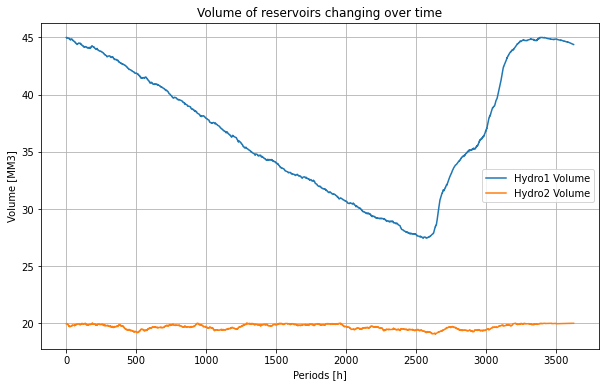

In [6]:
#RESERVOIR VOLUME
plot_vol(model)

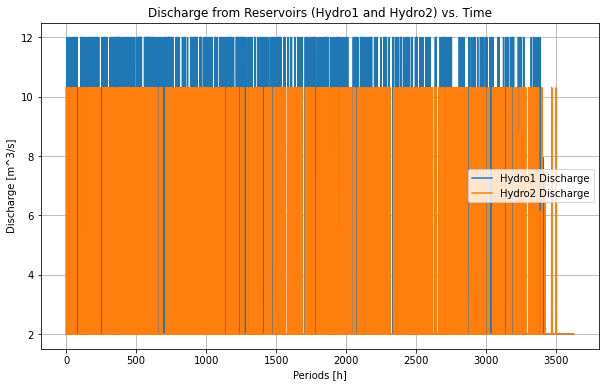

In [7]:
#RESERVOIR DISCHARGE
plot_disc(model)

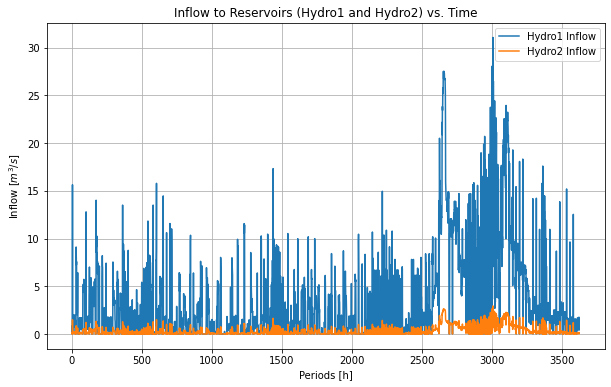

In [8]:
#Inflow to reservoirs
plot_inflow(model)

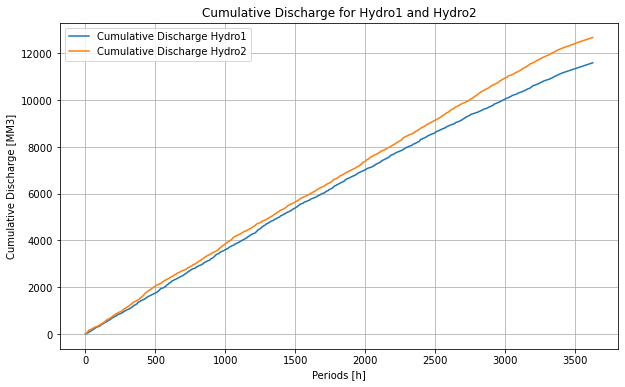

In [9]:
#Cumulative discharge
plot_cumq(model)

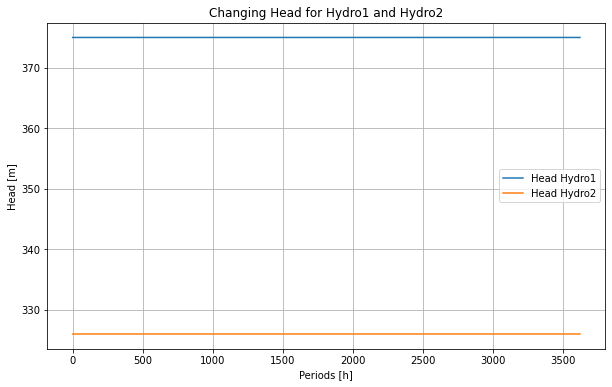

In [10]:
#Head
plot_head(model)

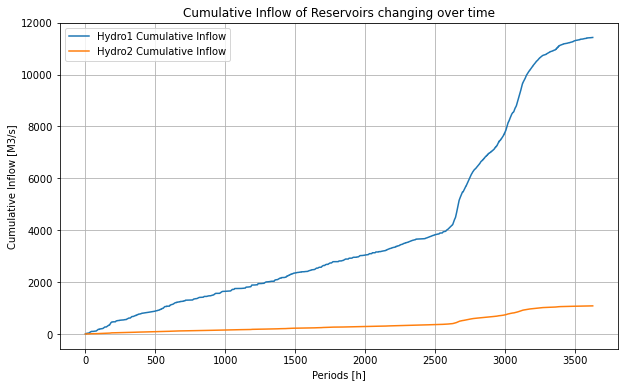

In [11]:
#Cumulative inflow
plot_cumin(model)

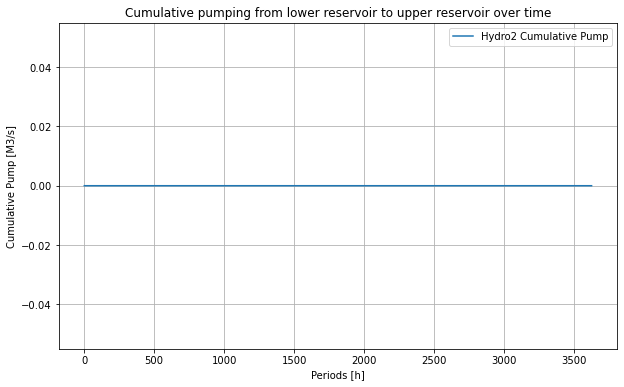

In [12]:
#Pump
plot_pump(model)

### Useful code for later 